# 3D printing a pluto data set

In [1]:
from pathlib import Path
import imageio

import numpy as np
from PIL import Image
from scipy.interpolate import RegularGridInterpolator

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astro3d
from astro3d.image_stack import makeslice, process

plt.style.use([{'image.cmap':'gray_r'}])

Read data.

In [3]:
with np.load(astro3d.get_data('pluto_data_norm.npz')) as f:
    x = f['x']
    y = f['y']
    z = f['z']
    data = f['rho']

## Normalization

Find the largest magnitude of the data values and define a logarithmic norm

In [4]:
vmax = 10**np.ceil(np.log10(data.max()))
norm = LogNorm(1e-2 * vmax, vmax, clip=True)

## Example plot

Select which slice to plot

In [5]:
i = 50

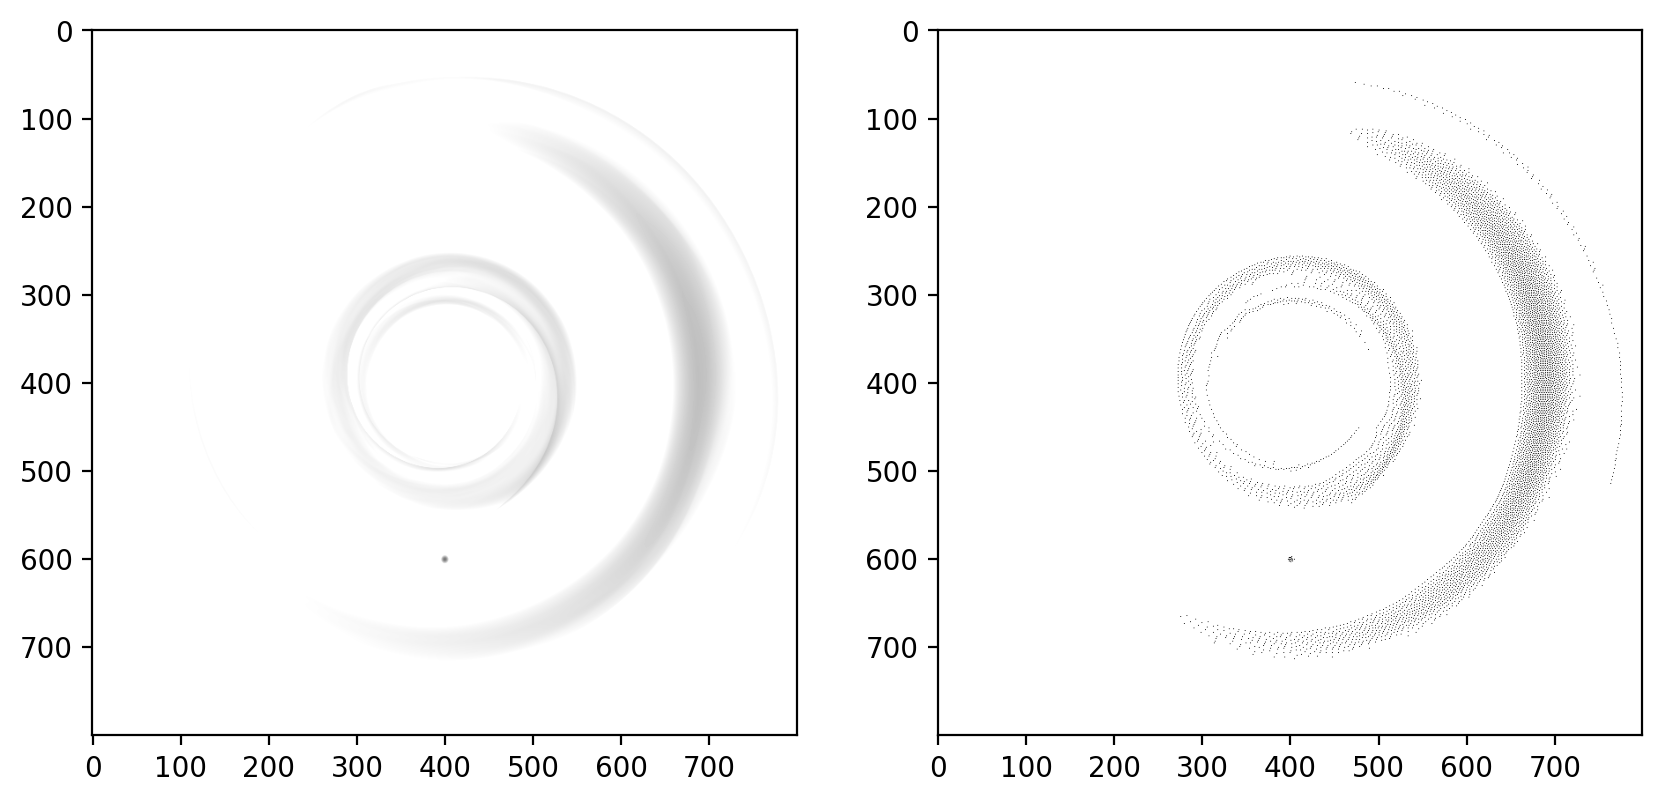

In [6]:
# apply the norm
d_0 = np.array(norm(data[:, :, i]))

# plot it and it's dithered version
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(d_0, vmin=0, vmax=1)
ax[1].imshow(astro3d.fmodule.dither(d_0), vmin=0, vmax=1);

## Upscale the data

### Coordinates & aspect ratios

these are the original "coordinates" of the pixels

In [7]:
x = np.arange(data.shape[0])
y = np.arange(data.shape[1])
z = np.arange(data.shape[2])

create an interpolation function for the 3d data

In [8]:
f_interp = RegularGridInterpolator((x, y, z), data)

settings of the printer (educated guess, especially the layer thickness might be different)

In [9]:
height = 2.5 # this should be the total height of the object. Other dimensions should be scaled to keep the aspect ratio

# these are the values according to alphacams website on the J850 Prime (Frank)
#dpi_x = 600
#dpi_y = 600
#dpi_z = 940  # 0.027 mm layer thickness

# these are the values used at FIT and alphacam
dpi_x = 600
dpi_y = 300
# dpi_z = 1814 # 0.014 mm layer thickness
dpi_z = 940 # 0.027 mm layer thickness

# layer_thickness = 2.54 / dpi_z#55e-4 # 14 micron

calculate the new grids in x, y, z

In [10]:
n_z = int(height * dpi_z / 2.54)
n_x = int(n_z * len(x) / len(z) / dpi_z * dpi_x)
n_y = int(n_z * len(y) / len(z) / dpi_z * dpi_y)

n_x += n_x % 2  # add 1 to make it even if it isn't
n_y += n_y % 2  # add 1 to make it even if it isn't

x2 = np.linspace(0, data.shape[0] - 1, n_x)
y2 = np.linspace(0, data.shape[1] - 1, n_y)
z2 = np.linspace(0, data.shape[2] - 1, n_z)

### Iteration

we get the new layer by interpolating the 3D data. We store the images in the path set by `output_dir`.

In [ ]:
output_dir = 'slices_pluto_v01'

Prepare output folder

In [ ]:
path = Path(output_dir)

if not path.is_dir():
    path.mkdir()
else:
    files = list(path.glob('slice*.png'))
    if len(files)>0:
        print('directory exists, deleting old files')
        for file in files:
            file.unlink()

select which index in the new z-grid to process

In [ ]:
iz = n_z//2

This cell does the same as `makeslice`: interpolates one layer, creates and dithers the image and writes it to file

In [ ]:
# update coordinates - only last entry changes
_x, _y, _z = np.meshgrid(x2, y2, [z2[0]], sparse=False, indexing='ij')
_z = np.array([[[z2[iz]]]])
coords = (_x, _y, _z)

# interpolate
new_layer = f_interp(coords)[:, :, 0].T

# normalize, convert to grayscale image
layer_norm = np.array(norm(new_layer))
layer_dither = astro3d.fmodule.dither(layer_norm)

# save as 1bit bitmap
imageio.imwrite(path / f'slice_{iz:04d}.png', np.uint8(255 - 255 * layer_dither))

In [ ]:
iz2 = z.searchsorted(z2[iz])

f, axs = plt.subplots(3, 1, dpi=100, figsize=(2*3, 3*3), constrained_layout=True)
axs[0].imshow(norm(data[:,:,iz2]).T, vmin=0, vmax=1, origin='lower')
axs[1].imshow(layer_norm, vmin=0, vmax=1, origin='lower')
axs[2].imshow(layer_dither, vmin=0, vmax=1, origin='lower')
axs[0].text(0.05, 0.95, 'step 1: original data, log-normalized', fontsize='small', transform=axs[0].transAxes)
axs[1].text(0.05, 0.95, 'step 2: interpolated to printer dimension', fontsize='small', transform=axs[1].transAxes)
axs[2].text(0.05, 0.95, 'step 3: dithered', fontsize='small', transform=axs[2].transAxes)

for ax in axs:
    ax.set_ylabel('y [pixel]')
    ax.set_anchor('W')
axs[-1].set_xlabel('x [pixel]');

this is the same result using `makeslice`, but one can select between 1 or 32 bit. stratasys voxelprint wants 32 bit.

In [ ]:
makeslice(iz, z2, f_interp, coords, norm, path)

get the colors in that slice

In [ ]:
im = Image.open(Path(output_dir) / f'slice_{iz:04d}.png')
colors = np.unique(np.array(im).reshape(-1, 4), axis=0)
print(f'There are {len(colors)} colors in this image:')
for row in colors:
    print(f'- {list(row)}')

f, ax = plt.subplots()
ax.imshow(im, vmin=0, vmax=254, origin='lower')
ax.set_xlabel('x [pixel]')
ax.set_ylabel('y [pixel]');

## Batch processing

all of the above can also be done in a loop with `process`:
normalizing with the given norm, up-scaling and saving to images. We'll just do this same one here by specifying the `iz` keyword.

Here we just want to print the first cm.

In [ ]:
iz = np.arange(int(dpi_z/2.54))

In [ ]:
process(data,
        height=height, dpi_x=dpi_x, dpi_y=dpi_y, dpi_z=dpi_z,
        output_dir=output_dir,
        norm=norm,
        #iz=iz
       )